<a href="https://colab.research.google.com/github/tasinfrancesco/Practical_ML_PSL/blob/main/NB9_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab Work 9: Time Series

This notebook builds on the same lecture of Foundations of Machine Learning. We'll focus on Time Series.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.


First the necessary imports:

In [18]:
!pip install -r requirements.txt
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import pandas as pd
from sktime.transformations.series.detrend import STLTransformer
from pandas.plotting import autocorrelation_plot
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.detection.bs import BinarySegmentation
from sktime.transformations.series.fourier import FourierFeatures
from sklearn.linear_model import LinearRegression

### Step 1: Download ERA5 Temperature Data

In this step, we show how to download ERA5 reanalysis temperature data at 2 meters above ground. This is just a demonstration: you can experiment with the code at home to download data for your own area of interest.

Key points:
-	We select the last month automatically.
-	We use a small region around Paris (20×20 grid points, ~5°×5°) to keep the dataset manageable.
-	The downloaded file is in NetCDF format, suitable for analysis with xarray.

Code explanation:
1.	Determine the last month:
We compute the first day of the current month and then go back one day to get the last day of the previous month.
2.	Download ERA5 data with cdsapi:
-	variable='2m_temperature' selects temperature at 2 meters.
-	area specifies the geographic box: [north, west, south, east].
-	time includes all hours of the day.
-	The data is saved locally as 'paris_20x20_last_month.nc'.

Note: The actual download requires an active CDS API account.

In [19]:
# import cdsapi
# import matplotlib.pyplot as plt
# from datetime import datetime, timedelta

# # -----------------------------
# # 1. Determine last month
# # -----------------------------
# today = datetime.today()
# first_day_this_month = datetime(today.year, today.month, 1)
# last_month_end = first_day_this_month - timedelta(days=1)
# last_month_start = datetime(last_month_end.year, last_month_end.month, 1)

# year = str(last_month_start.year)
# month = str(last_month_start.month).zfill(2)

# print(f"Downloading ERA5 temperature data for {year}-{month}")

# # -----------------------------
# # 2. Download ERA5 data (2m temp)
# # -----------------------------
# c = cdsapi.Client()

# # Paris approx: 48.8566 N, 2.3522 E
# # ERA5 grid 0.25° -> 20x20 ~ 5°x5° box
# area = [51.0, -0.5, 46.0, 4.5]  # north, west, south, east

# # c.retrieve(
# #     'reanalysis-era5-single-levels',
# #     {
# #         'product_type':'reanalysis',
# #         'variable':'2m_temperature',
# #         'year': year,
# #         'month': [month],
# #         'day':[str(d).zfill(2) for d in range(1, last_month_end.day+1)],
# #         'time':[f"{h:02d}:00" for h in range(0,24)],
# #         'area': area,
# #         'format':'netcdf'
# #     },
# #     'paris_20x20_last_month.nc'
# # )



### Step 2: Load ERA5 NetCDF Data and Visualize a Single Cell

Once the ERA5 data file is downloaded, we can explore it directly in Python. We use h5py to read the NetCDF/HDF5 file.

Key points:
1.	Explore the file structure:
	-	NetCDF4/HDF5 files store variables in hierarchical groups.
	-	Use list(f.keys()) to see top-level groups like temperature, latitude, longitude, and time.
2.	Access data arrays:
	-	t2m: 2-meter temperature (shape: time × lat × lon).
	-	latitude and longitude: grid coordinates.
	-	valid_time (or time): timestamps.
3.	Unit conversion:
ERA5 temperatures are in Kelvin; convert to Celsius by subtracting 273.15.
4.	Plot a single cell over time:
Pick a grid point (e.g., cell (10,10)) and visualize the temperature time series. This helps to get familiar with the data and check for trends or patterns.

Tip: You can change the cell indices to visualize other locations or plot multiple cells together.

Top-level groups: ['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m']
Temperature shape: (720, 21, 21)


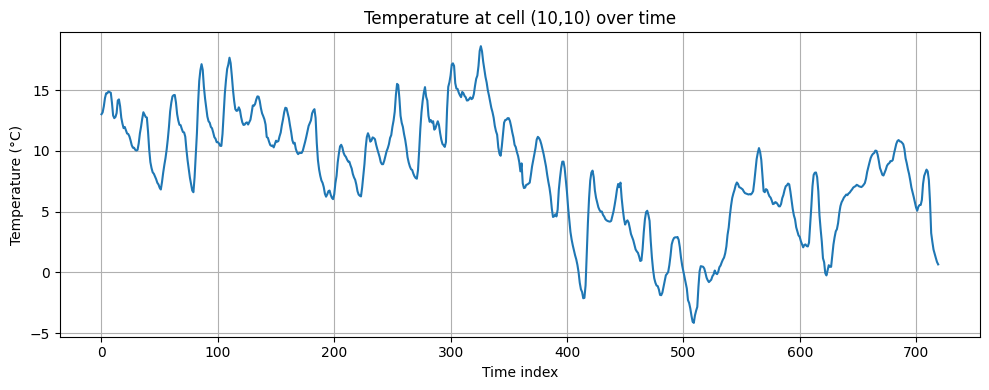

In [20]:


# -----------------------------
# 3. Load NetCDF4/HDF5 with h5py
# -----------------------------
f = h5py.File("paris_20x20_last_month.nc", "r")

print("Top-level groups:", list(f.keys()))

# NetCDF4 stores dimensions as variables too
T = f["t2m"][:]              # temperature array (time, lat, lon)
lat = f["latitude"][:]       # name may differ
lon = f["longitude"][:]
time = f["valid_time"][:]

print("Temperature shape:", T.shape)

# Convert to Celsius once
T_C = T - 273.15

# -----------------------------
# 4. Plot a single cell over time
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(T_C[:, 10, 10], lw=1.5)
plt.xlabel("Time index")
plt.ylabel("Temperature (°C)")
plt.title("Temperature at cell (10,10) over time")
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 3: Plot a 2D Temperature Field on a Geographic Map

In this step, we visualize the ERA5 temperature field for a given time index directly on a real geographic map using Cartopy.

This teaches students how to:
-	Project gridded climate data onto maps
-	Add geographic context (coastlines, borders, land, water)
-	Annotate maps with city names
-	Control map extent and resolution

We use:
-	pcolormesh to plot the 20×20 temperature grid
-	Cartopy’s PlateCarree projection (suitable for lat–lon data)
-	Natural Earth shapefiles to locate major populated places

Key idea:
ERA5 already provides latitude–longitude grids, so mapping requires only passing transform=ccrs.PlateCarree().

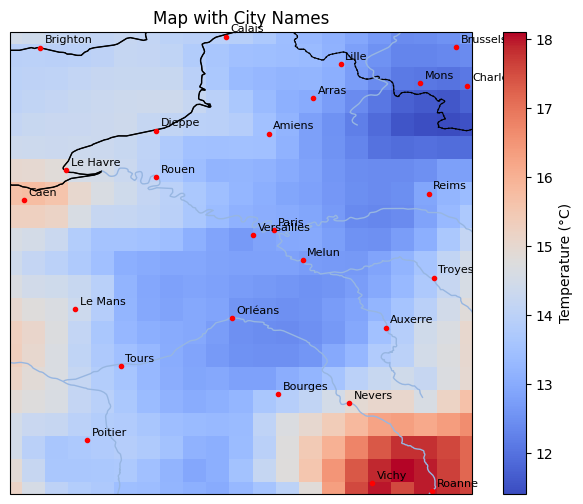

In [21]:


time_index = 12  # or whatever

# meshgrid for pcolormesh
lon2d, lat2d = np.meshgrid(lon, lat)

plt.figure(figsize=(8, 6))

ax = plt.axes(projection=ccrs.PlateCarree())

# add real map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# plot heatmap
pcm = ax.pcolormesh(lon2d, lat2d, T_C[time_index],
                    cmap="coolwarm",
                    transform=ccrs.PlateCarree())

plt.colorbar(pcm, ax=ax, label="Temperature (°C)")

ax.set_title(f"ERA5 Temperature + real map (timestep={time_index})")

# set map extent to the bounding box you requested
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()],
              crs=ccrs.PlateCarree())

# plt.show()

# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
#
# import matplotlib.pyplot as plt

# # your bounding box
extent = [-0.5, 4.5, 46.0, 51.0]

# fig = plt.figure(figsize=(8, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# base map features
ax.add_feature(cfeature.LAND, zorder=0)
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.add_feature(cfeature.RIVERS)

# --------------------------------
# ADD CITY NAMES (from Natural Earth)
# --------------------------------
shpfilename = shpreader.natural_earth(
    resolution='10m',
    category='cultural',
    name='populated_places'
)
cities = shpreader.Reader(shpfilename).records()

for city in cities:
    lon_bis, lat_bis = city.geometry.x, city.geometry.y
    # Only label cities inside your bounding box
    if extent[0] <= lon_bis <= extent[1] and extent[2] <= lat_bis <= extent[3]:
        ax.plot(lon_bis, lat_bis, marker='o', markersize=3, color='red')
        ax.text(lon_bis + 0.05, lat_bis + 0.05, city.attributes['NAME'],
                fontsize=8, transform=ccrs.PlateCarree())

plt.title("Map with City Names")
plt.show()

### Step 4: Extract and Compare Time Series in a Spatial Neighborhood

In this step, we focus on spatio–temporal structure of the ERA5 dataset.

We pick a central grid cell and extract the temperature time series for a 3×3 spatial neighborhood around it.
The goal is to visualize how nearby locations vary over time and to start discussing spatial correlation.

What this step teaches:
-	How to index 3D climate data: (time, lat, lon)
-	How to construct multiple time series from nearby grid points
-	How to convert raw timestamps into pandas.DatetimeIndex
-	How to visualize many time series on the same plot

                     cell_-10_-10  cell_-10_0  cell_-10_10  cell_0_-10  \
time                                                                     
2025-11-01 00:00:00     15.371735   14.055328    13.260406   13.895172   
2025-11-01 01:00:00     15.201080   14.079987    13.310455   13.613190   
2025-11-01 02:00:00     14.591949   14.433746    13.256012   13.636871   
2025-11-01 03:00:00     13.748688   14.572906    13.190094   13.654938   
2025-11-01 04:00:00     13.500275   14.209259    13.277618   13.371368   

                      cell_0_0  cell_0_10  cell_10_-10  cell_10_0  cell_10_10  
time                                                                           
2025-11-01 00:00:00  13.020172  10.990875    16.412750  13.512360   13.963531  
2025-11-01 01:00:00  13.173737  11.259674    16.607330  13.306549   13.908112  
2025-11-01 02:00:00  13.670074  11.947418    16.531403  13.539215   13.851715  
2025-11-01 03:00:00  14.352203  12.574860    16.346344  13.988922   14.098297  
2

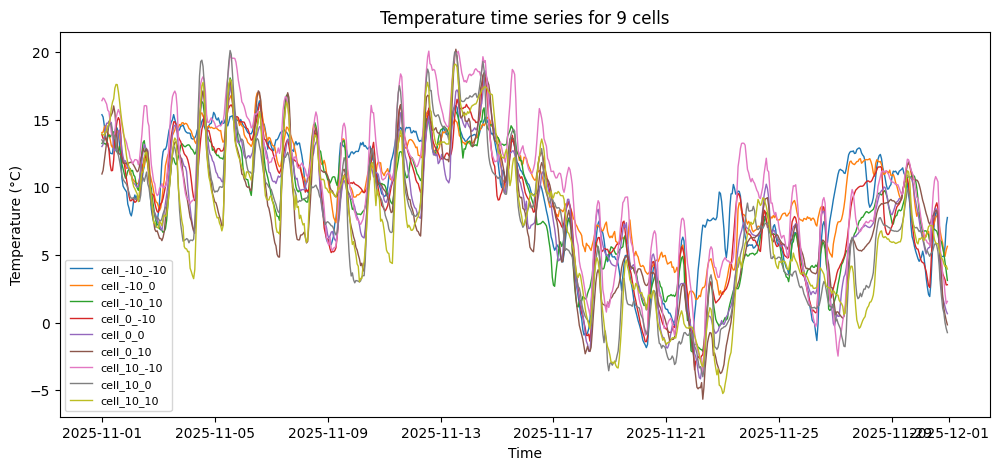

In [22]:
# pick center cell
i, j = 10, 10

# reference time
ref_time = pd.Timestamp("1970-01-01")
dt_index = [ref_time + pd.to_timedelta(s, unit='s') for s in time]
ind=10
# 3x3 neighborhood
ts_neighbors = {}            #important here as the temperature between close-by areas should be similar-ish
for di in [-ind, 0, ind]:
    for dj in [-ind, 0, ind]:
        key = f"cell_{di}_{dj}"
        ts_neighbors[key] = T_C[:, i + di, j + dj]

# build a DataFrame: columns = cells, index = datetime
df_neighbors = pd.DataFrame(ts_neighbors, index=dt_index)
df_neighbors.index.name = "time"

print(df_neighbors.head())
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
for col in df_neighbors.columns:
    plt.plot(df_neighbors.index, df_neighbors[col], label=col, lw=1)
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature time series for 9 cells" )
plt.legend(fontsize=8)
plt.show()

### Step 5: STL Decomposition of a Temperature Time Series

In this step, we analyse the temporal structure of the temperature signal at a single grid cell using **STL decomposition** (Seasonal–Trend decomposition using Loess).

We select the central cell and separate its temperature series into:
- **Trend** (long-term evolution)
- **Seasonal component** (daily cycle)
- **Residual** (short-term fluctuations)


LOESS (LOcally WEighted Scatterplot Smoothing) for Seasonality and Trend, reweighted for Residuals.

What this step teaches:
- How to isolate different temporal scales in a climate time series
- How seasonal decomposition works and why it is useful
- How to visualize original data and decomposed components together
- How to interpret the residual as the “anomaly” of the signal

Students should run STL on the central cell, inspect the three components,  
and compare them to the original temperature series.

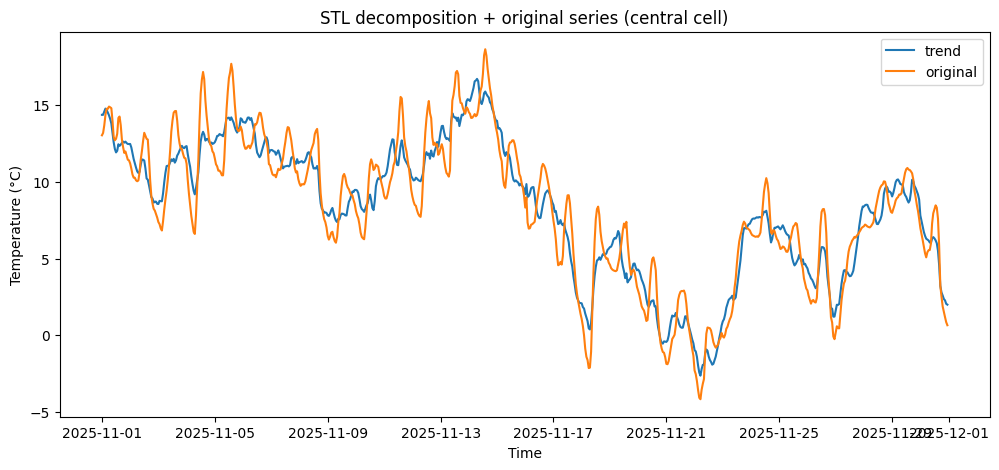

In [23]:


# select the central cell
ts = df_neighbors["cell_0_0"]

# STL decomposition
stl = STLTransformer(sp=24)  #you need to give the seasonality (24h in this case)
components = stl.fit_transform(ts)   #final model will be TREND (LOESS(Y-seasonality)) + SEASONALITY (Take points every 24h and add LOESS) + RESIDUALS

# ensure components is a DataFrame
if isinstance(components, pd.Series):
    components = components.to_frame(name="trend")  # you can rename as needed

# Add original series
components['original'] = ts

# Plot all on the same figure
plt.figure(figsize=(12,5))
for col in components.columns:
    plt.plot(components.index, components[col], label=col)
plt.title("STL decomposition + original series (central cell)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

### Step 5: Autocorrelation Analysis

Autocorrelation measures how a time series correlates with **lagged versions of itself**.  
It is useful for detecting:
- periodicity (daily, weekly patterns)
- persistence (how long “memory” lasts)
- whether a series is mostly noise or structured



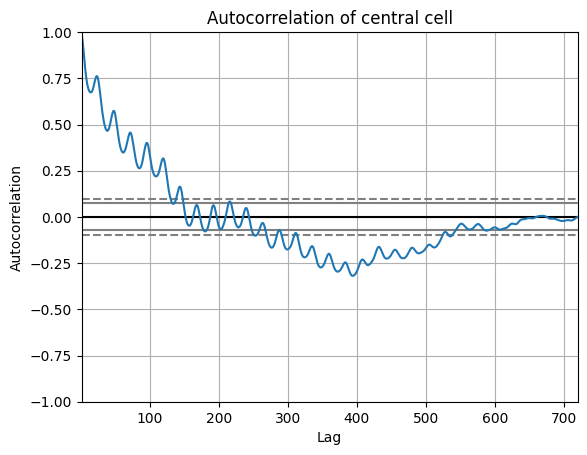

In [24]:
autocorrelation_plot(ts)
plt.title("Autocorrelation of central cell")
plt.show()

Step 6: Naive Forecasting

In this step, we implement a simple baseline forecast for the temperature time series at a single grid cell.

Objective: Introduce the concept of a naive forecast, which assumes that the future will be the same as the most recent observation. This provides a benchmark for more sophisticated models.

What this step teaches:
-	How to split a time series into training and testing sets.
-	How to implement a naive forecast (repeat last observed value).
-	How to visualize predictions against actual measurements.
-	How to interpret forecast performance as a baseline for comparison.

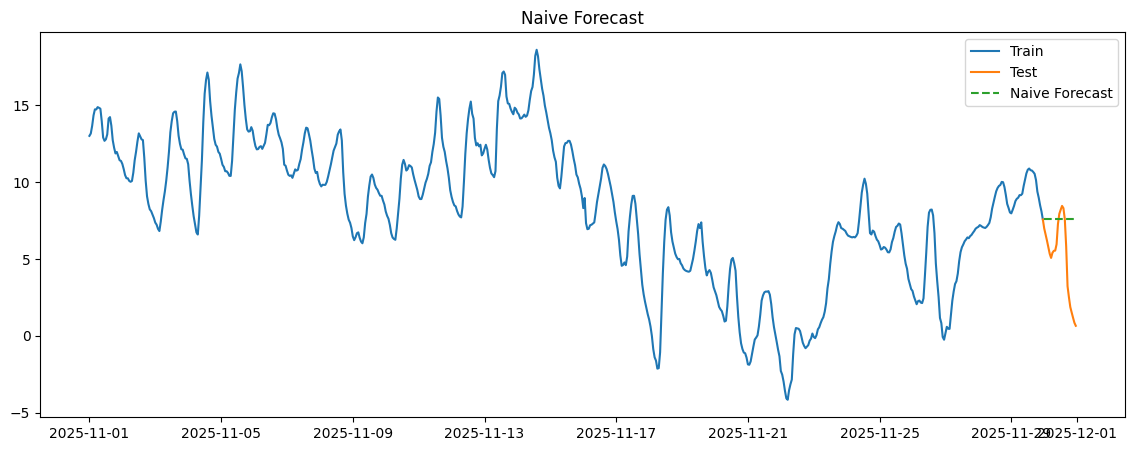

In [25]:

# last 24 hours
train = ts[:-24]
test = ts[-24:]

# naive forecast: repeat last value
naive_forecast = pd.Series([train.iloc[-1]]*len(test), index=test.index)

plt.figure(figsize=(14,5))
plt.plot(train, label="Train")
plt.plot(ts[-25:], label="Test")
plt.plot(naive_forecast, label="Naive Forecast", linestyle="--")
plt.title("Naive Forecast")
plt.legend()
plt.show()

Step 7: Seasonal Naive Forecasting

In this step, we extend the naive forecast to account for seasonality in the time series.

Objective: Use the observation from exactly one day ago (24 hours) as the forecast for the next 24 hours. This is called a seasonal naive forecast.

What this step teaches:
-	How to incorporate seasonality into a simple baseline forecast.
-	How to shift a time series to create seasonal predictions.
-	How to align predictions with the test period using pandas indexing.
-	How to visualize the forecast compared to the actual series.

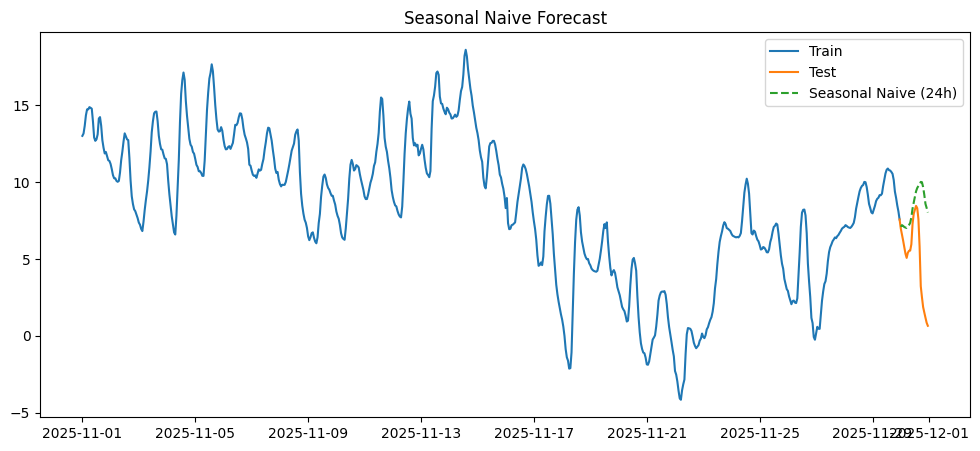

In [26]:
seasonal_naive = train.shift(24).iloc[-24:]
seasonal_naive.index = test.index  # align index

plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(ts[-25:], label="Test")
plt.plot(seasonal_naive, label="Seasonal Naive (24h)", linestyle="--")
plt.title("Seasonal Naive Forecast")
plt.legend()
plt.show()

### Step 8: Rolling Mean Forecast

In this step, we implement a **rolling mean forecast**, which predicts the next values using the **average of the last N observations**.

**Objective:** Use the mean of the last 24 hours of the training data to forecast the next 24 hours.  

**What this step teaches:**
- How to compute a **moving average** or rolling mean in pandas.
- How to use past observations to smooth out short-term fluctuations and capture local trends.
- How to align the rolling forecast with the test period.
- How to visualize the rolling mean forecast compared to the original time series.

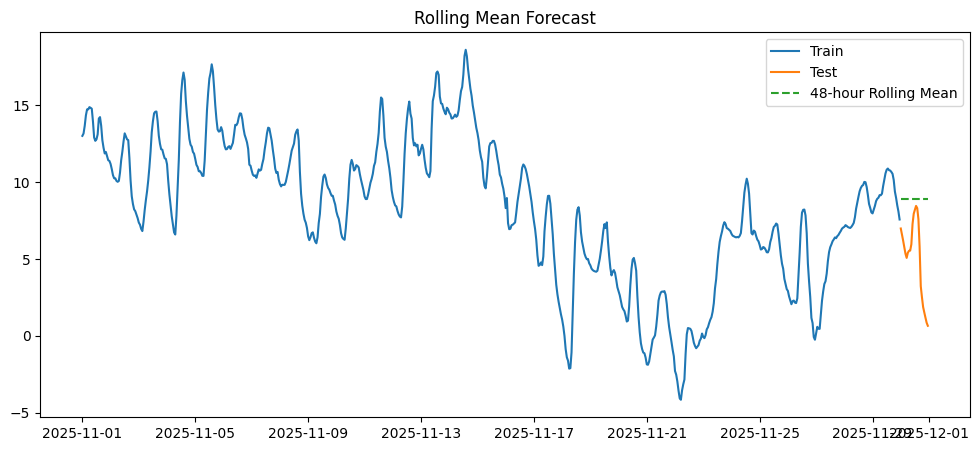

In [27]:
window = 48  # last 24 hours
rolling_forecast = pd.Series([train[-window:].mean()]*len(test), index=test.index)

plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(rolling_forecast, label=f"{window}-hour Rolling Mean", linestyle="--")
plt.title("Rolling Mean Forecast")
plt.legend()
plt.show()

### Step 9: ARIMA Forecast with sktime

In this step, we fit an **ARIMA (AutoRegressive Integrated Moving Average)** model to the temperature time series.

**Objectives:**
- Use a **recent window of data** (last 7 days) for forecasting.
- Capture **daily seasonality** in temperature (24-hour period).
- Forecast the next 24 hours and compare with the observed values.

**What this step teaches:**
- How to prepare time series for ARIMA in `sktime`.
- How to split the data into training and test sets using `temporal_train_test_split`.
- How to define a **forecasting horizon** for predictions.
- How to fit `AutoARIMA` and generate forecasts.
- How to visualize forecasts alongside the original series.

**Key points:**
- ARIMA can automatically identify the best order parameters for the model.
- Including seasonal periods allows the model to account for **daily cycles**.
- Using a moving window for training helps capture **recent trends** while reducing the effect of older data.

To estimate an ARIMA(\(p,d,q\)) model on a time series \(y_t\), three main steps are used:

1. **Differencing (the “I” part)**  
   If $d>0$, the series is differenced \(d\) times to make it stationary:  
   $z_t = \Delta^d y_t$.

2. **Fitting an ARMA model to \(z_t\)**  
   The differenced series is modeled as an ARMA(\(p,q\)):
  $z_t = \sum_{i=1}^p \phi_i z_{t-i} +
         \sum_{j=1}^q \theta_j \varepsilon_{t-j} +
         \varepsilon_t.
   $
   The parameters $\phi_i$, $\theta_j$, and the noise variance $\sigma^2$ are estimated via  
   **maximum likelihood (MLE)** using numerical optimization (often with the Kalman filter).

3. **Diagnostics**  
   After estimation, we check:
   - whether residuals behave like white noise,
   - model quality using AIC/BIC,
   - normality and independence of errors.

/tmp/ipython-input-1739699017.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = ts.asfreq('H')  # hourly frequency
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to est

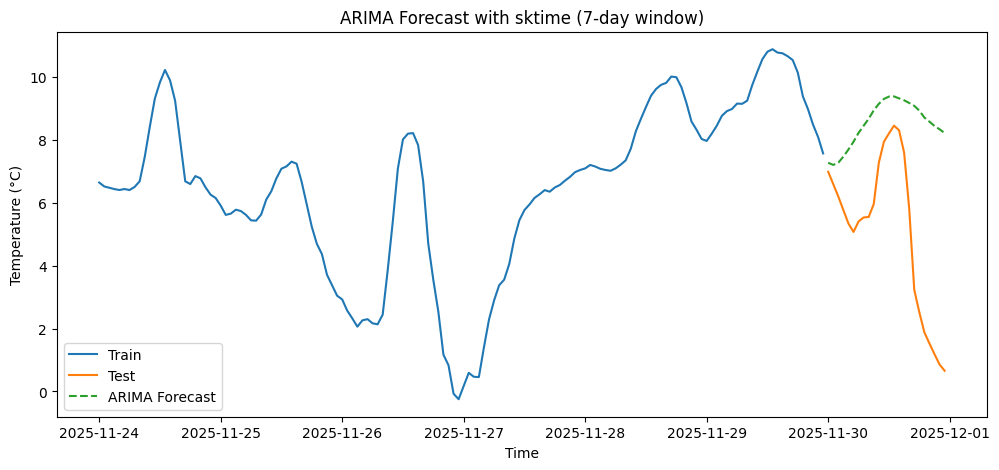

In [28]:


# -----------------------------
# Ensure hourly frequency
# -----------------------------
ts = ts.asfreq('H')  # hourly frequency

# -----------------------------
# Use only last N hours for training (e.g., 7 days)
# -----------------------------
window_hours = 7*24  # 7 days
y = ts[-window_hours:]  # take last 7 days

# -----------------------------
# Split last 24h for testing
# -----------------------------
y_train, y_test = temporal_train_test_split(y, test_size=24)

# -----------------------------
# Define forecasting horizon
# -----------------------------
fh = ForecastingHorizon(y_test.index, is_relative=False)

# -----------------------------
# Fit ARIMA model
# -----------------------------
forecaster = AutoARIMA(sp=24)  # daily seasonality
forecaster.fit(y_train)

# -----------------------------
# Forecast next 24 hours
# -----------------------------
y_pred = forecaster.predict(fh)

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(y_train, label="Train")
plt.plot(y_test, label="Test")
plt.plot(y_pred, label="ARIMA Forecast", linestyle="--")
plt.title("ARIMA Forecast with sktime (7-day window)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

### Step 10: Multi-step Forecast with Random Forest using Neighboring Cells

In this step, we leverage **spatial and temporal information** to forecast the temperature at a central grid cell.

**Key ideas:**
- Use **lagged values** of the target cell (last 48 hours) as features.
- Include **neighboring cells** as exogenous features.
- Train a **Random Forest Regressor** to predict future temperature.
- Perform **multi-step forecasting**, where each predicted step is fed back for the next forecast.

**What this step teaches:**
- How to construct **lagged features** for time series forecasting.
- How to include **exogenous variables** (neighboring cells) in the prediction.
- How to perform **recursive multi-step forecasting**.
- How to visualize the **forecast alongside historical data and neighbors**.

**Plot interpretation:**
- Black/orange lines: observed temperature of the central cell (train/test).
- Green dashed line: forecast for the central cell.
- Gray lines: temperatures of neighboring cells.
- Helps assess how spatial correlation contributes to forecast performance.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

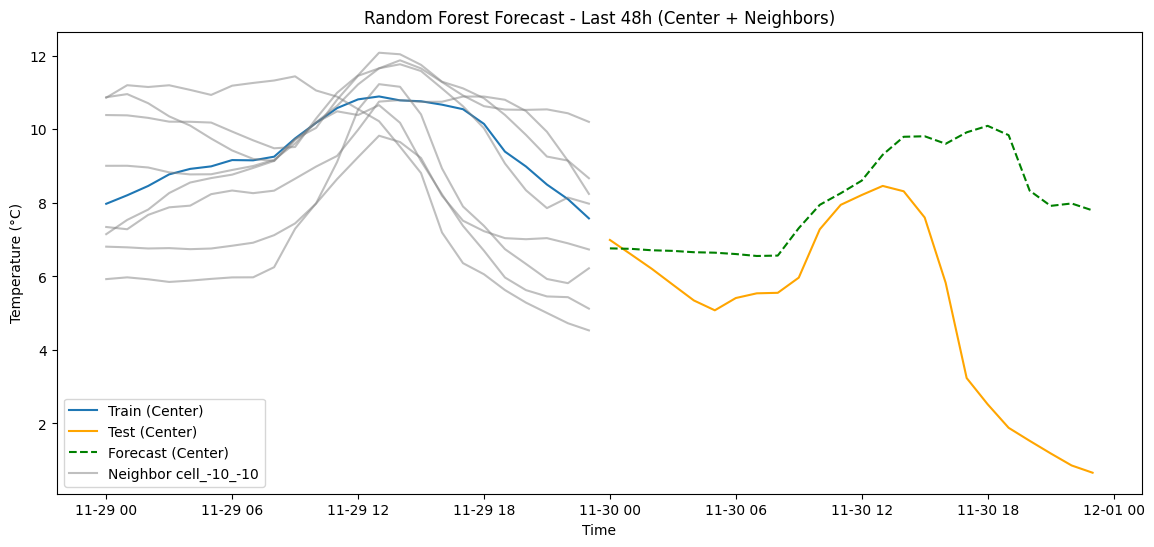

In [29]:


# -----------------------------
# Parameters
# -----------------------------
lags = 2*24      # past hours of target to use
horizon = 24      # forecast horizon
plot_hours = 48   # last 48 hours to plot

# -----------------------------
# Prepare data
# -----------------------------
y = df_neighbors["cell_0_0"].asfreq('h')  # target
X = df_neighbors.drop(columns="cell_0_0").asfreq('h')  # neighbors

# -----------------------------
# Split last 24h as test
# -----------------------------
y_train, y_test = temporal_train_test_split(y, test_size=horizon)
X_train, X_test = temporal_train_test_split(X, test_size=horizon)

# -----------------------------
# Create lagged features function
# -----------------------------
def create_lagged_features(y_series, X_exog, lags):
    df = pd.DataFrame()
    for i in range(1, lags+1):
        df[f"y_lag_{i}"] = y_series.shift(i)
    df = pd.concat([df, X_exog], axis=1)
    df = df.dropna()
    return df

# -----------------------------
# Prepare training data
# -----------------------------
df_train = create_lagged_features(y_train, X_train, lags)
y_train_lagged = y_train[df_train.index]

# -----------------------------
# Train Random Forest
# -----------------------------
model = RandomForestRegressor(n_estimators=400, random_state=42)
model.fit(df_train, y_train_lagged)

# -----------------------------
# Multi-step forecast (using "future" neighbors)
# -----------------------------
y_pred = []
last_target = y_train[-lags:].values.copy()

for t in range(horizon):
    X_step = X_test.iloc[t].values.reshape(1, -1)  # using neighbors like ARIMA
    features = np.concatenate([last_target[-lags:], X_step.flatten()]).reshape(1, -1)
    y_next = model.predict(features)[0]
    y_pred.append(y_next)
    last_target = np.append(last_target, y_next)

# -----------------------------
# Plot last 48 hours including prediction and neighbors
# -----------------------------
start_plot = -plot_hours if plot_hours < len(y_train) + len(y_test) else - (len(y_train) + len(y_test))
time_index = y.index[start_plot:]

plt.figure(figsize=(14,6))

# Plot center cell
plt.plot(y.index[start_plot: -horizon], y.values[start_plot: -horizon], label="Train (Center)")
plt.plot(y_test.index, y_test.values, label="Test (Center)", color='orange')
plt.plot(y_test.index, y_pred, label="Forecast (Center)", linestyle="--", color='green')

# Plot neighbors
for col in X.columns:
    plt.plot(X.index[start_plot: -horizon], X[col].values[start_plot: -horizon], color='gray', alpha=0.5, label=f"Neighbor {col}" if col==X.columns[0] else "")

plt.title("Random Forest Forecast - Last 48h (Center + Neighbors)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

### Step 11: Change Point Detection with Binary Segmentation

In this step, we detect **abrupt changes** in the temperature time series of a single cell using the **Binary Segmentation** algorithm.

**Key ideas:**
- Binary Segmentation recursively partitions the time series to find points where the **mean level changes significantly**.
- The `threshold` parameter controls the **sensitivity**: lower thresholds detect smaller changes, higher thresholds detect only large shifts.
- Change points can reveal **regime shifts, sudden events, or anomalies** in the data.

**What this step teaches:**
- How to apply **change point detection** on a single time series.
- How to visualize **predicted change points** on the original series.
- How to interpret abrupt changes in a spatio-temporal dataset.

**Plot interpretation:**
- Black line: observed temperature of the cell.
- Red dashed lines: predicted change points where the algorithm detected significant shifts.
- Helps identify **temporal events** that may require further investigation or preprocessing.

Predicted change points (indices):    ilocs
0    383


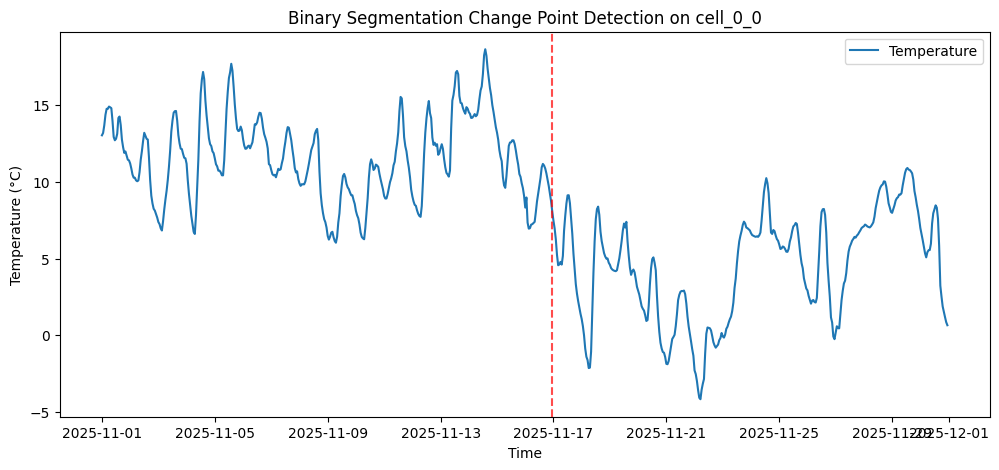

In [30]:


# -----------------------------
# Select single cell
# -----------------------------
y = df_neighbors["cell_0_0"].asfreq('h')

# -----------------------------
# Initialize BinarySegmentation detector
# -----------------------------
model = BinarySegmentation(threshold=40.0)  # adjust threshold as needed
predicted_change_points = model.fit_predict(y)

print("Predicted change points (indices):", predicted_change_points)

# Extract indices as a list of integers
cp_indices = predicted_change_points['ilocs'].tolist()

# Clip indices to valid range just in case
cp_indices = [cp for cp in cp_indices if cp < len(y)]

# Plot
plt.figure(figsize=(12,5))
plt.plot(y.index, y.values, label="Temperature")
for cp in cp_indices:
    plt.axvline(y.index[cp], color='red', linestyle='--', alpha=0.7)
plt.title("Binary Segmentation Change Point Detection on cell_0_0")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

### Step 12: Spatial Correlation Analysis

In this step, we study how the **temperature time series of nearby cells are correlated** with a central cell as a function of **spatial distance**.

**Key concepts:**
- For each distance from the central cell, we select a **3×3 neighborhood**.
- Compute the **Pearson correlation** of each neighbor's time series with the central cell.
- Average correlations (excluding the central cell) to quantify the **typical spatial similarity** at that distance.

**What this step teaches:**
- How to explore **spatial structure** in gridded climate data.
- How correlation decreases as we move farther from a reference point.
- Visualization of **mean correlation vs distance** highlights the spatial coherence of the field.

**Plot interpretation:**
- X-axis: distance from the central cell (in grid units).
- Y-axis: mean correlation of neighbors with the central cell.
- Shows how **temperature similarity decays with distance**, which is important for spatial modeling and forecasting.

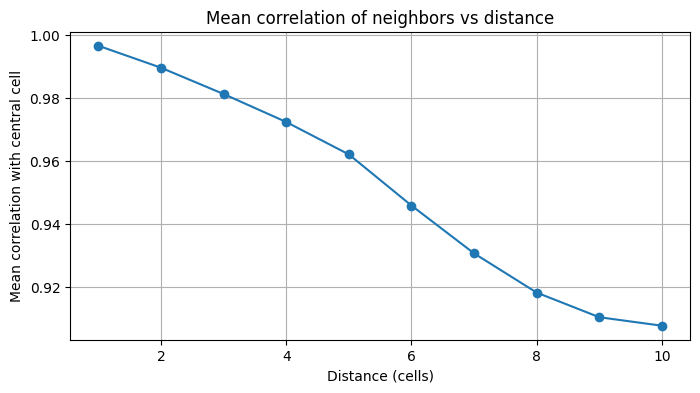

In [31]:


# -----------------------------
# Parameters
# -----------------------------
i, j = 10, 10             # central cell
max_distance = 10         # max spatial distance
ref_time = pd.Timestamp("1970-01-01")
dt_index = [ref_time + pd.to_timedelta(s, unit='s') for s in time]

mean_correlations = []

# -----------------------------
# Loop over distances
# -----------------------------
for ind in range(1, max_distance + 1):
    # 3x3 neighborhood at this distance
    ts_neighbors = {}
    for di in [-ind, 0, ind]:
        for dj in [-ind, 0, ind]:
            key = f"cell_{di}_{dj}"
            ts_neighbors[key] = T_C[:, i + di, j + dj]

    df_neighbors = pd.DataFrame(ts_neighbors, index=dt_index)
    central = df_neighbors["cell_0_0"]

    # correlation of all neighbors with central
    correlations = df_neighbors.corrwith(central)

    # exclude central cell itself
    mean_corr = correlations.drop("cell_0_0").mean()
    mean_correlations.append(mean_corr)

# -----------------------------
# Plot mean correlation vs distance
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(range(1, max_distance+1), mean_correlations, marker='o')
plt.title("Mean correlation of neighbors vs distance")
plt.xlabel("Distance (cells)")
plt.ylabel("Mean correlation with central cell")
plt.grid(True)
plt.show()

### Step 13: Fourier-based Decomposition of a Single Cell

In this step, we analyze the **temporal periodicity** of a single grid cell using **Fourier features**.

**Key concepts:**
- Fourier features approximate the **cyclical patterns** (e.g., daily cycles) in the time series.
- A **linear regression** on these Fourier features reconstructs the **periodic component** of the signal.
- The **residual** highlights the non-periodic, irregular variations remaining after removing dominant cycles.

**What this step teaches:**
- How to extract and quantify **periodic patterns** in time series.
- The relationship between **Fourier terms and seasonal components**.
- How to separate **regular oscillations from irregular fluctuations**.

**Plot interpretation:**
- **Black line:** Original temperature time series.
- **Green line:** Reconstructed periodic component from Fourier terms.
- **Orange line:** Residual (non-periodic variations), useful for anomaly detection or further modeling.

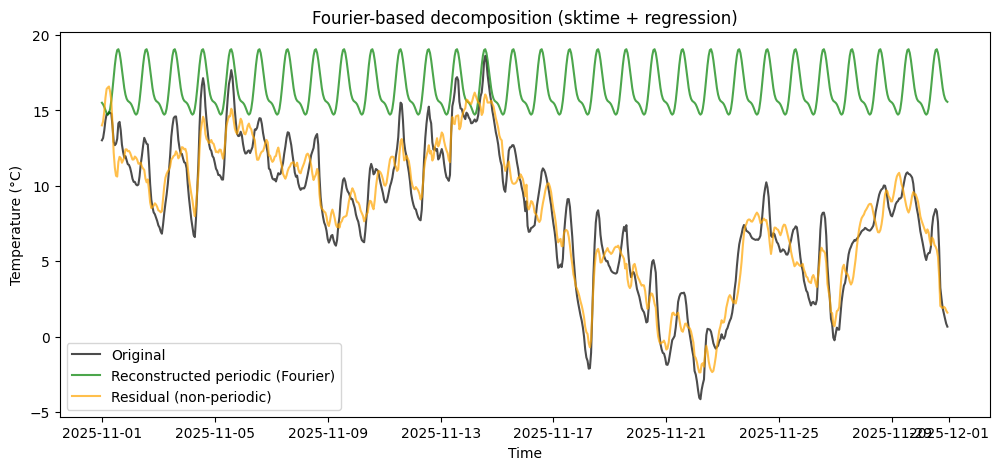

In [32]:



# -----------------------------
# Pick a single cell
# -----------------------------
i, j = 10, 10
ts = T_C[:, i, j]  # shape (time,)
ref_time = pd.Timestamp("1970-01-01")
dt_index = [ref_time + pd.to_timedelta(s, unit='s') for s in time]
ts = pd.Series(ts, index=dt_index)
ts.index.name = "time"

# -----------------------------
# Compute Fourier features
# -----------------------------
sp_list = [24]          # daily period
fourier_terms = 2     # number of Fourier terms
transformer = FourierFeatures(sp_list=sp_list, fourier_terms_list=[fourier_terms])
ff = transformer.fit_transform(ts.to_frame(name="cell"))

# -----------------------------
# Fit linear regression to approximate signal with Fourier terms
# -----------------------------
lr = LinearRegression().fit(ff, ts.values)
reconstruction = lr.predict(ff)  # reconstructed periodic part
reconstruction += ts.mean()
ts_residual = ts - reconstruction+reconstruction.mean()

# -----------------------------
# Plot original, reconstructed periodic, and residual
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values, label="Original", color='black', alpha=0.7)
plt.plot(ts.index, reconstruction, label="Reconstructed periodic (Fourier)", color='green', alpha=0.7)
plt.plot(ts.index, ts_residual, label="Residual (non-periodic)", color='orange', alpha=0.7)
plt.title("Fourier-based decomposition (sktime + regression)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()